# 3f. Evaluate demand predictions for patients yet to arrive

In notebook 3e, I showed how to predict demand from patients yet to arrive, using models that learn arrival rates from past data. In this notebook, I evaluate those arrival rate predictions against observed arrivals in the test set.

Predictions for patients yet-to-arrive are made up of two components:

* Arrival rates calculated from past data, prepared for a series of time intervals within a prediction window after the moment of prediction
* A probability of admission for any patient arriving within one of these time intervals being admitted within the prediction window. The probability of admission is generated using either an empirical survival curve, or an aspirational approach.

We can evaluate these two components separately. First I evaluate the arrival rates, by comparing the arrival rates learned from the training set against observed arrival rates during the test set. Then I evaluate a survival-curve-based model, comparing its predicted bed count distributions against observed admissions.

### About the data used in this notebook

You can request the UCLH datasets on [Zenodo](https://zenodo.org/records/14866057). If you don't have the public data, change `data_folder_name` from `'data-public'` to `'data-synthetic'`.

In [1]:
# Reload functions every time
%load_ext autoreload
%autoreload 2

## Load data and train models

The data loading and model training steps were demonstrated in detail in previous notebooks. Here I use `prepare_prediction_inputs`, a convenience function that performs all of these steps in a single call.

In [2]:
from patientflow.train.emergency_demand import prepare_prediction_inputs

data_folder_name = 'data-public'
prediction_inputs = prepare_prediction_inputs(data_folder_name)

# Unpack the results
ed_visits = prediction_inputs['ed_visits']
inpatient_arrivals = prediction_inputs['inpatient_arrivals']
params = prediction_inputs['config']

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]

Processing: (6, 0)



Processing: (9, 30)



Processing: (12, 0)



Processing: (15, 30)



Processing: (22, 0)


Below I use the training, validation and test set dates set in `config.yaml` to retrieve the portions of the data needed for evaluation.

In [3]:
import pandas as pd
from datetime import timedelta
from patientflow.prepare import create_temporal_splits

# Extract config parameters
start_training_set = params['start_training_set']
start_validation_set = params['start_validation_set']
start_test_set = params['start_test_set']
end_test_set = params['end_test_set']

# Create temporal splits for inpatient arrivals
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(
    inpatient_arrivals['arrival_datetime'], utc=True
)
_, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='arrival_datetime',
)

Split sizes: [7716, 1285, 3898]


## Evaluating arrival rates

We can compare the arrival rates learned from the training set against observed arrival rates at the front door of the ED during the test set.

To illustrate, I start by plotting the cumulative arrivals of patients later admitted within a prediction window on one date. In the upper chart, the blue line shows the cumulative number of arrivals. The orange line shows the cumulative mean arrival rate.

The lower chart shows the delta between the two lines.

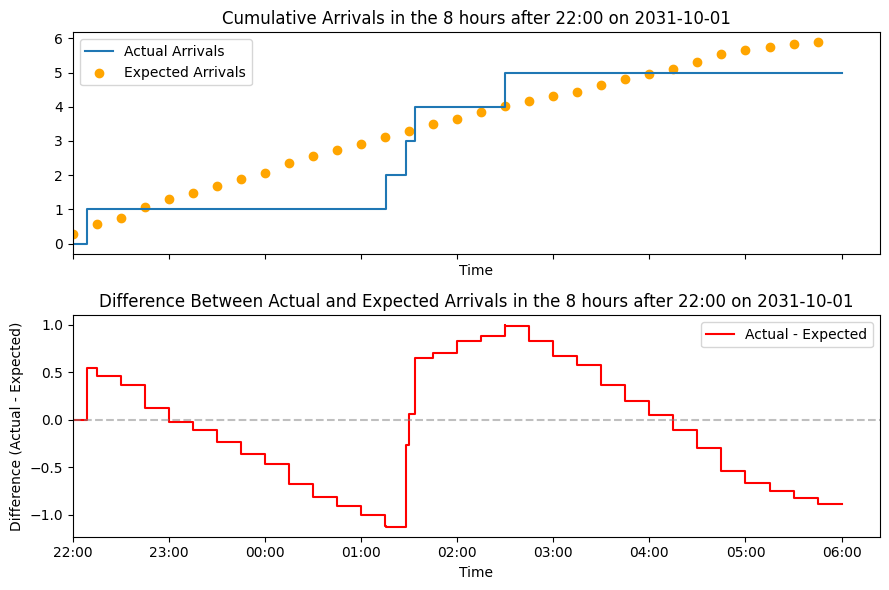

In [4]:
from patientflow.viz.observed_against_expected import plot_arrival_delta_single_instance
from datetime import timedelta

plot_arrival_delta_single_instance(test_inpatient_arrivals_df, 
                        prediction_time=(22,0), 
                        snapshot_date=start_test_set, 
                        show_delta=True, 
                        prediction_window=timedelta(minutes=params["prediction_window"]), 
                        yta_time_interval = timedelta(minutes=params["yta_time_interval"]),
                        fig_size=(9, 3)
                        )

The chart below shows multiple versions of the delta for each date in the test set, for each prediction time, with the average delta shown in red.

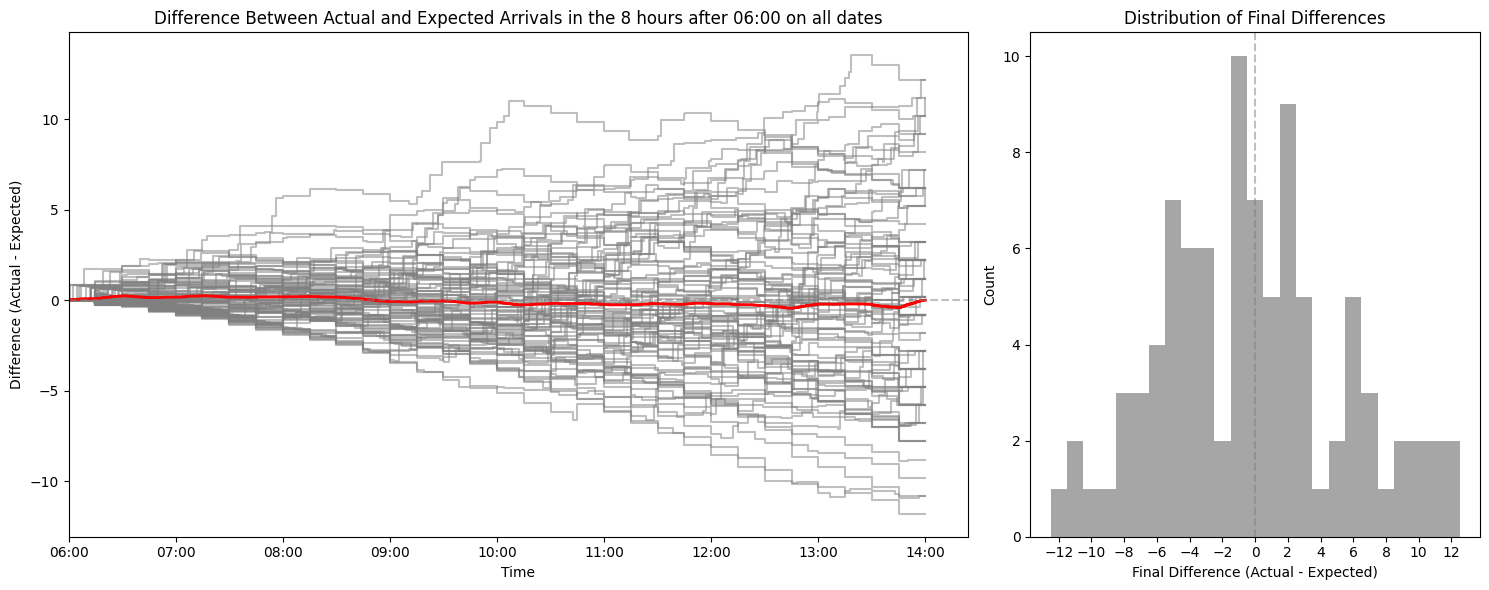

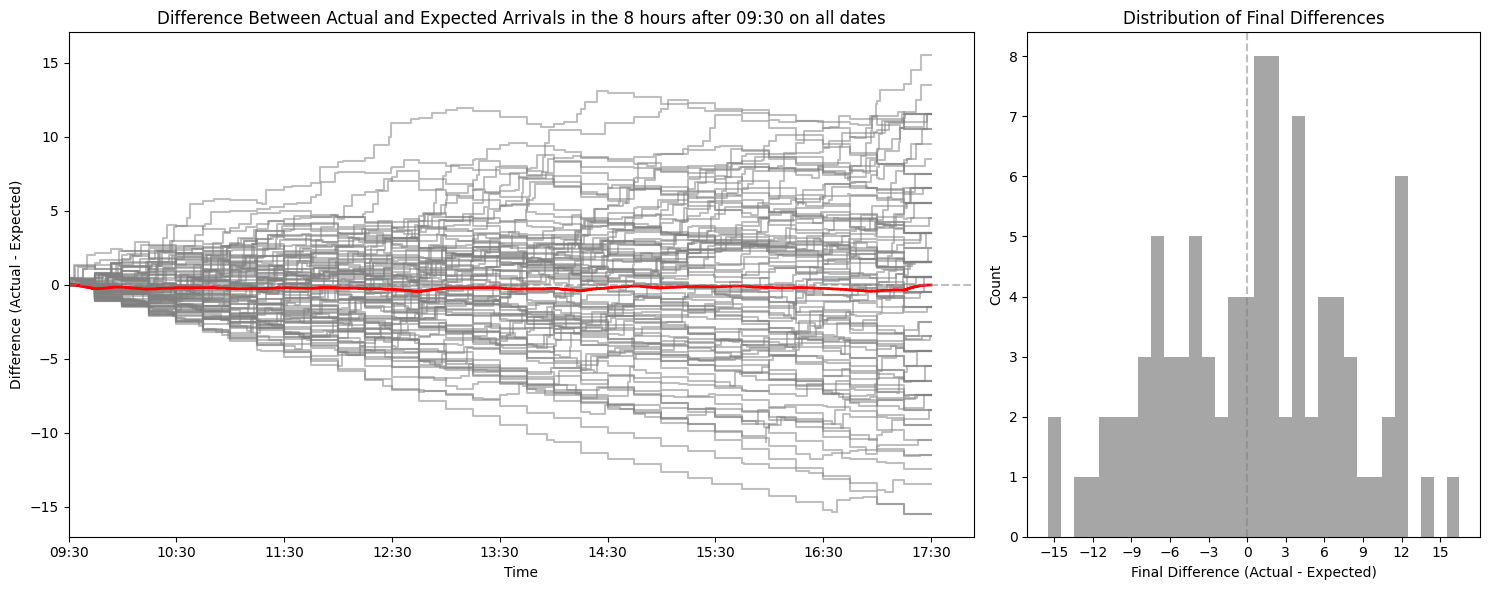

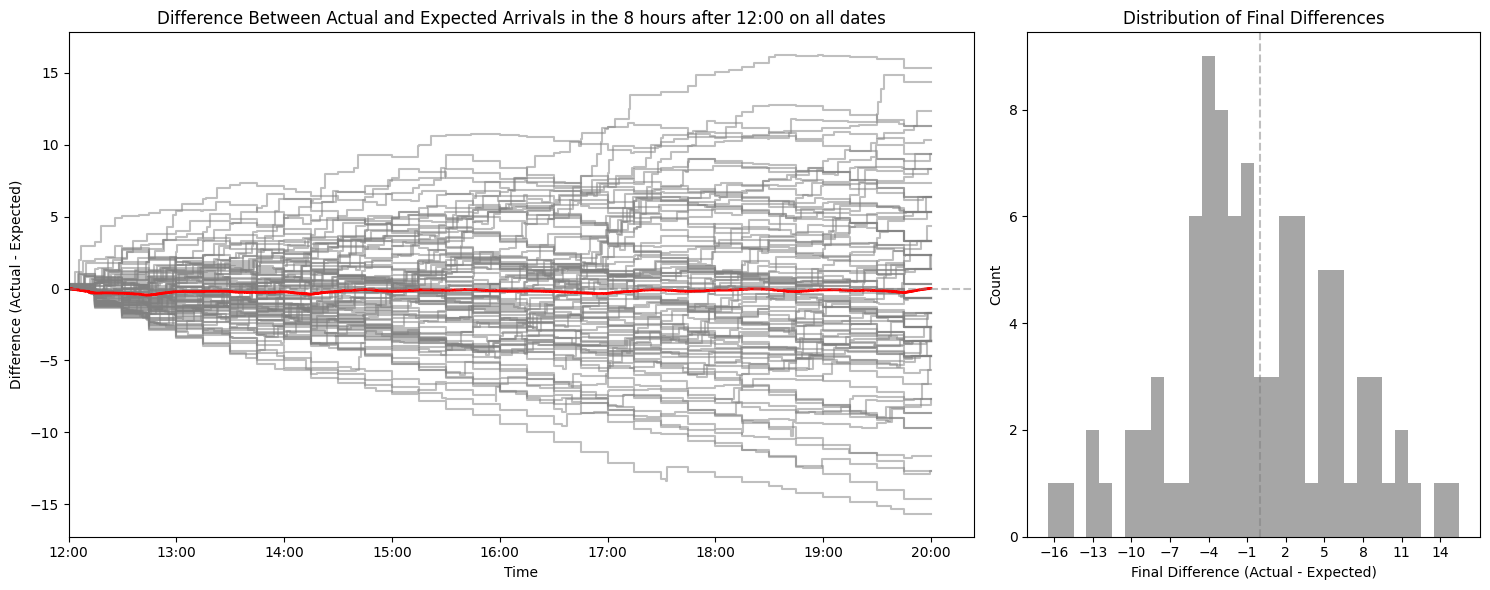

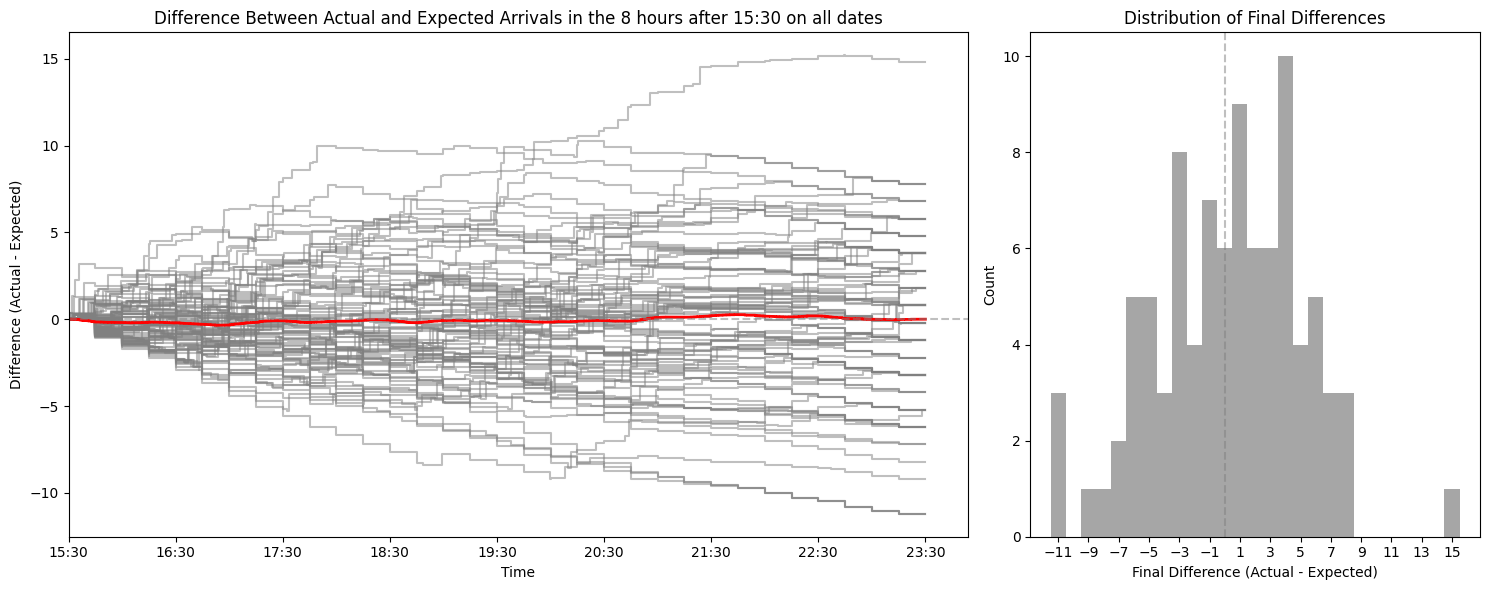

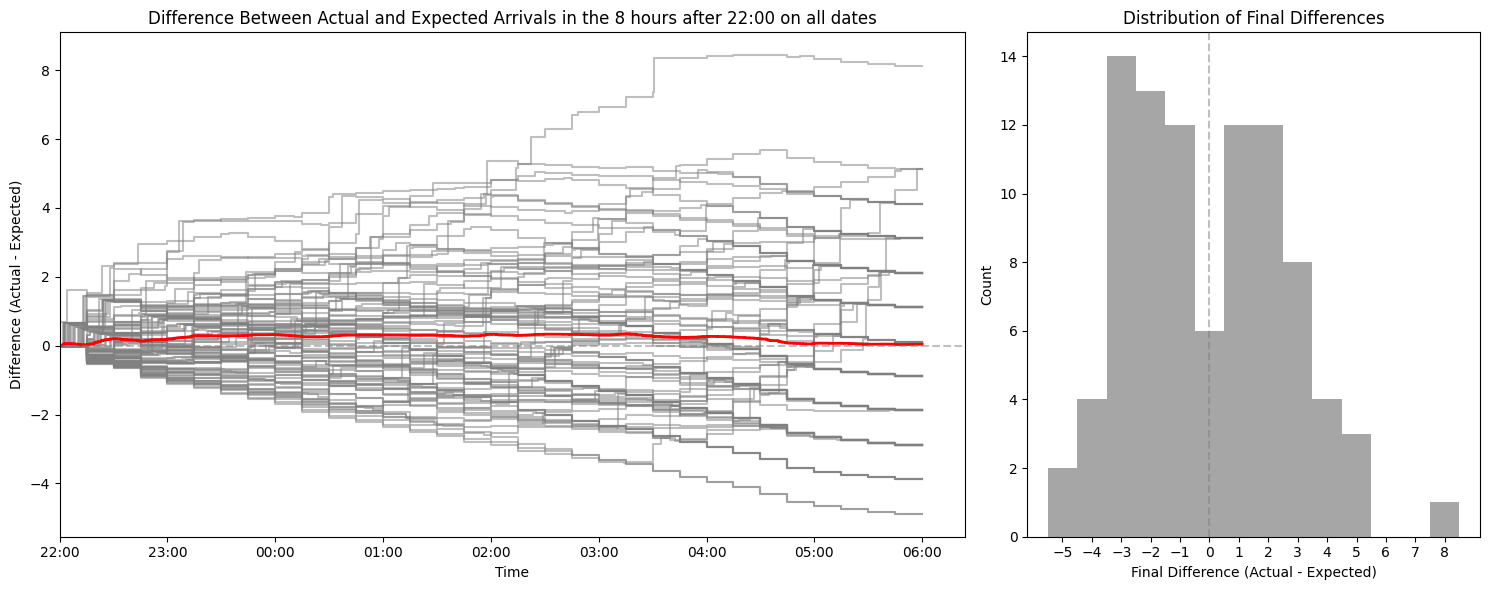

In [5]:
from patientflow.viz.observed_against_expected import plot_arrival_deltas
from datetime import timedelta


start_date = start_test_set
end_date = end_test_set
snapshot_dates = []

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

# Sort prediction times by converting to minutes since midnight
prediction_times_sorted = sorted(
    ed_visits.prediction_time.unique(),
    key=lambda x: x[0] * 60 + x[1],
)

for prediction_time in prediction_times_sorted:
    plot_arrival_deltas(test_inpatient_arrivals_df, 
                         prediction_time, 
                         snapshot_dates, 
                        prediction_window=timedelta(minutes=params["prediction_window"]), 
                        yta_time_interval = timedelta(minutes=params["yta_time_interval"])
                         )

## Evaluate predictions using survival curves

In notebook 3e, I demonstrated an `EmpiricalIncomingAdmissionPredictor` that uses a survival curve to estimate how long patients take to be admitted after arriving at the ED. To evaluate that model, I need data with both arrival and admission-to-ward times — which is not available in the public dataset used above. Instead, I use the same fake data as in notebook 3e.

First I generate the fake data and train the model.

In [6]:
import pandas as pd
from datetime import date, timedelta
from patientflow.generate import create_fake_finished_visits
from patientflow.prepare import create_temporal_splits
from patientflow.predictors.incoming_admission_predictors import EmpiricalIncomingAdmissionPredictor

# Generate fake data with both arrival and admission-to-ward times
visits_df, _, _ = create_fake_finished_visits('2023-01-01', '2023-04-01', mean_patients_per_day=50, admitted_only=True)
inpatient_arrivals_fake = visits_df.rename(columns={'departure_datetime': 'admitted_to_ward_datetime'}).drop(columns='is_admitted')
inpatient_arrivals_fake['arrival_datetime'] = pd.to_datetime(inpatient_arrivals_fake['arrival_datetime'])

# Temporal splits
start_training_set_fake = date(2023, 1, 1)
start_validation_set_fake = date(2023, 2, 15)
start_test_set_fake = date(2023, 3, 1)
end_test_set_fake = date(2023, 4, 1)

train_visits, valid_visits, test_visits = create_temporal_splits(
    inpatient_arrivals_fake,
    start_training_set_fake,
    start_validation_set_fake,
    start_test_set_fake,
    end_test_set_fake,
    col_name="arrival_datetime",
)

# Train the EmpiricalIncomingAdmissionPredictor
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
num_days = (start_validation_set_fake - start_training_set_fake).days

train_visits_copy = train_visits.copy(deep=True)
if 'arrival_datetime' in train_visits_copy.columns:
    train_visits_copy.set_index('arrival_datetime', inplace=True)

yta_model_empirical = EmpiricalIncomingAdmissionPredictor(verbose=True)
yta_model_empirical.fit(
    train_visits_copy,
    prediction_window=timedelta(hours=8),
    yta_time_interval=timedelta(minutes=15),
    prediction_times=prediction_times,
    num_days=num_days,
    start_time_col='arrival_datetime',
    end_time_col='admitted_to_ward_datetime'
)

Split sizes: [2214, 710, 1584]
Calculating time-varying arrival rates for data provided, which spans 45 unique dates


EmpiricalIncomingAdmissionPredictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]


using prediction window of 8:00:00 after the time of prediction


and time interval of 0:15:00 within the prediction window.


The error value for prediction will be 1e-07


To see the weights saved by this model, used the get_weights() method


EmpiricalIncomingAdmissionPredictor has been fitted with survival curve containing 881 time points


EmpiricalIncomingAdmissionPredictor(filters={}, verbose=True)

### Compare survival curves across train, validation and test sets

The survival curve plot function can be used with multiple datasets. This may be useful to check whether the ED has become slower to process patients over time — such a difference would show up as a gap between the curves. We encountered this issue in our own work, and showed how to mitigate it using a sliding window approach for the survival curve in our [Nature Digital Medicine paper](https://www.nature.com/articles/s41746-022-00649-y). The problem does not show up below because these curves are based on synthetic data, but it might in your dataset.

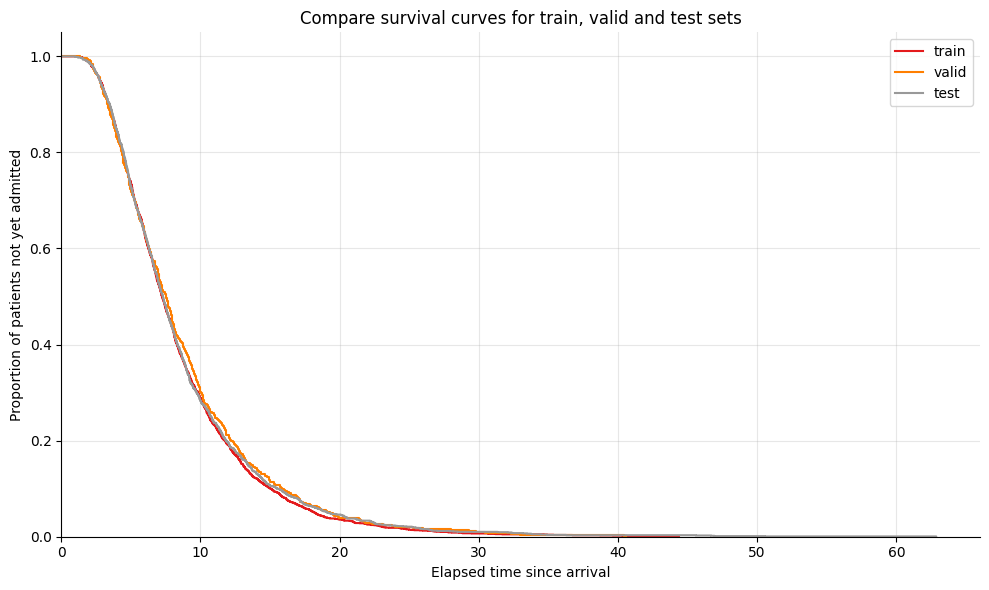

In [7]:
from patientflow.viz.survival_curve import plot_admission_time_survival_curve

title = 'Compare survival curves for train, valid and test sets'
plot_admission_time_survival_curve(
    [train_visits, valid_visits, test_visits],
    labels=['train', 'valid', 'test'],
    start_time_col="arrival_datetime",
    end_time_col="admitted_to_ward_datetime",
    title=title,
    ylabel='Proportion of patients not yet admitted',
    xlabel='Elapsed time since arrival',
    return_df=False
)

### Compare predicted with observed bed counts

The function below compares the predicted bed count distributions from the `EmpiricalIncomingAdmissionPredictor` with the observed counts of patients who arrived and were admitted within the prediction window, for each date in the test set.

In [8]:
from patientflow.aggregate import get_prob_dist_using_survival_curve
from patientflow.load import get_model_key

snapshot_dates_fake = []
current_date = start_test_set_fake
while current_date < end_test_set_fake:
    snapshot_dates_fake.append(current_date)
    current_date += timedelta(days=1)

prob_dist_dict_all_fake = {}

for prediction_time in prediction_times:
    model_key = get_model_key('yet_to_arrive', prediction_time)
    prob_dist_dict_all_fake[model_key] = get_prob_dist_using_survival_curve(
        snapshot_dates=snapshot_dates_fake,
        test_visits=test_visits,
        category='unfiltered',
        prediction_time=prediction_time,
        prediction_window=timedelta(minutes=8*60),
        start_time_col='arrival_datetime',
        end_time_col='admitted_to_ward_datetime',
        model=yta_model_empirical,
        verbose=False,
    )

The result can be plotted using EPUDD plots. The model appears as a series of vertical lines because the `EmpiricalIncomingAdmissionPredictor` is trained only on time of day, so there is minimal variation in the predicted distributions. This is included as a placeholder, to show how modelling of yet-to-arrive patients using past data on time to admission could be evaluated. You could modify the function to include a weekday/weekend variable, or replace it with a different approach based on moving averages (such as ARIMA).

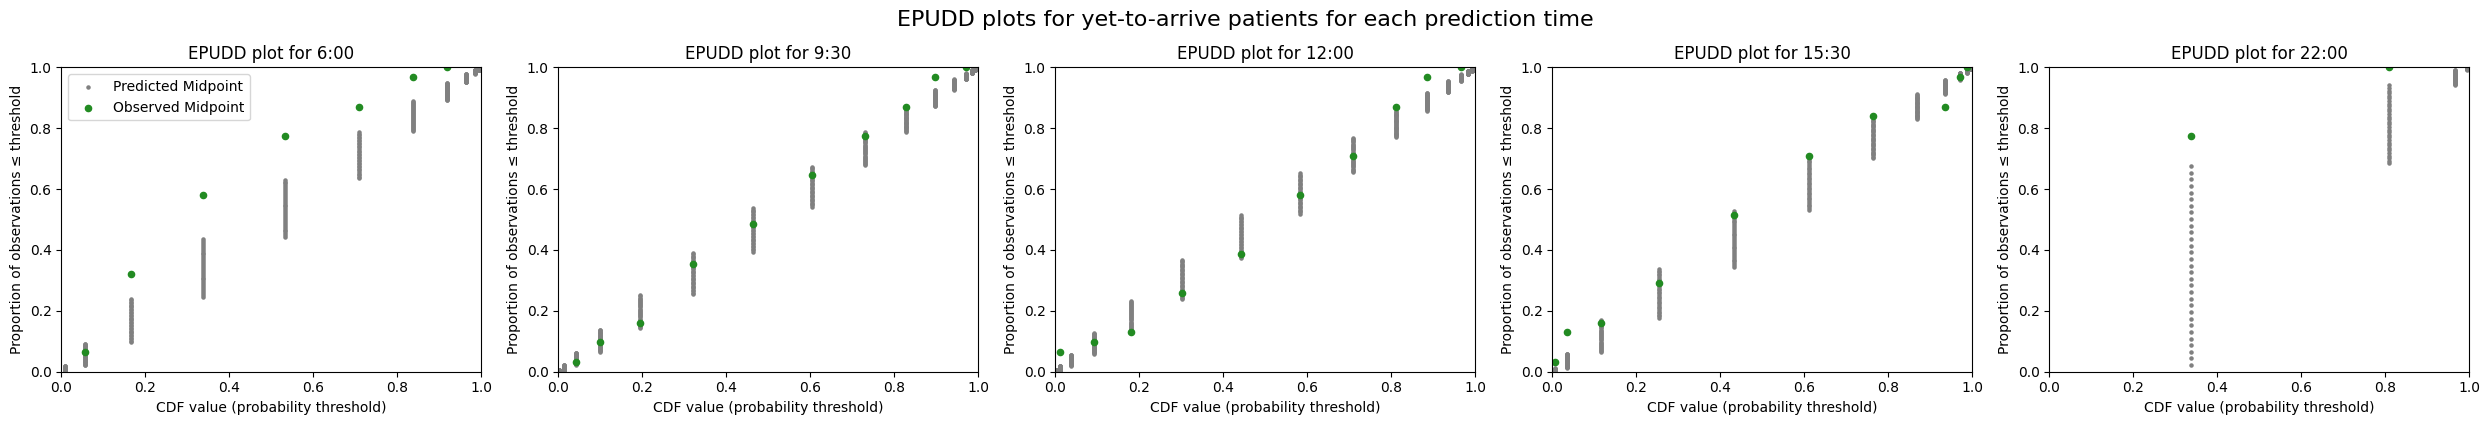

In [9]:
from patientflow.viz.epudd import plot_epudd

plot_epudd(prediction_times,
           prob_dist_dict_all_fake,
           model_name='yet_to_arrive',
           suptitle="EPUDD plots for yet-to-arrive patients for each prediction time",
           plot_all_bounds=False)

## Summary

In this notebook I have shown two approaches to evaluating predictions for patients yet to arrive:

* Comparing the mean arrival rates learned from the training set against observed arrivals during the test set, to assess whether the arrival rate model is well calibrated.
* Comparing predicted bed count distributions from a survival-curve-based model against observed admissions, using EPUDD plots.

The survival curve evaluation used fake data because the public dataset does not include admission-to-ward times. If your data includes these times, you can apply the same approach to your real data. Comparing survival curves across training and test periods is a useful diagnostic for detecting whether ED performance has changed over time.

In the notebooks that follow, I demonstrate a fully worked example of how these functions are used at University College London Hospital to predict emergency demand.